In [1]:
# directory to  data input
DATA_DIR = 'C:/Users/emman/OneDrive - GLASGOW CALEDONIAN UNIVERSITY/Documents/GCU/Trimester C/Dissertation/Assessments/Datasets'

# directory to root models
ROOT_DIR = 'C:/Users/emman/OneDrive - GLASGOW CALEDONIAN UNIVERSITY/Documents/GCU/Trimester C/Dissertation/Assessments/Source Codes'

# directory to Mask R-CNN model
MODEL_DIR = 'C:/Users/emman/OneDrive - GLASGOW CALEDONIAN UNIVERSITY/Documents/GCU/Trimester C/Dissertation/Assessments/Source Codes/Mask_RCNN'

# directory to Mask R-CNN checkpoints
CHECKPOINT_DIR = 'C:/Users/emman/OneDrive - GLASGOW CALEDONIAN UNIVERSITY/Documents/GCU/Trimester C/Dissertation/Assessments/Source Codes/Mask_RCNN/checkpoints'

# directory to Mask R-CNN logs
LOG_DIR = 'C:/Users/emman/OneDrive - GLASGOW CALEDONIAN UNIVERSITY/Documents/GCU/Trimester C/Dissertation/Assessments/Source Codes/Mask_RCNN/logs/pnuemonia_detection'

In [2]:
#import os
#os.chdir(ROOT_DIR)

# clone the repository
#!git clone https://github.com/matterport/Mask_RCNN.git Mask_RCNN

In [3]:
#import os
#os.chdir(os.path.join(ROOT_DIR, 'Mask_RCNN'))

# install mask r-cnn dependencies
#!pip install -r requirements.txt

In [4]:
# run the setup file
#!python ./setup.py install

In [5]:
# import libraries
import os
import random
import cv2
import glob
import pydicom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [6]:
# import Mask-RCNN
# find local version of the library
import os
os.chdir(os.path.join(ROOT_DIR, 'Mask_RCNN/mrcnn'))

import mrcnn.model as modellib
from mrcnn import utils
from mrcnn import config
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.config import Config

Using TensorFlow backend.


### Load the dataset

In [7]:
# load the datasets
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [8]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns):
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows():
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations

### Examine the annotation data, parse the dataset, and view dicom fields

In [9]:
# training dataset
import os
os.chdir(DATA_DIR)

anns = pd.read_csv('./stage_2_train_labels.csv')
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [10]:
%%time
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

Wall time: 6.43 s


In [11]:
# read dicom image from filepath
ds = pydicom.read_file(image_fps[0])

# get image array
image = ds.pixel_array

In [12]:
# original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets

In [13]:
# split dataset into training vs. validation dataset
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

25184 1500


### Set configuration variables

In [14]:
# The following parameters have been selected to reduce running time for demonstration purposes
# These are not optimal

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """

    # Give the configuration a recognizable name
    NAME = 'pneumonia'

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    BACKBONE = 'resnet50'

    NUM_CLASSES = 2  # background + 1 pneumonia classes

    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES   

### Create and prepare the training dataset using the DetectorDataset class.

In [15]:
# create the detector dataset class
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)

        # add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')

        # add images
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp,
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # if grayscale. convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(bool), class_ids.astype(np.int32)

In [16]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Let's evaluate the model's performance
For this, we will use the standard mAP and mAR metrics

In [46]:
# custom configurations for inference
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BACKBONE = 'resnet101'
    USE_MINI_MASK = False

# load the configuration
inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES  

In [47]:
# change working directory
os.chdir(LOG_DIR)

# create the Mask R-CNN model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          model_dir='./resnet101_complete_1GPU_25epochs',
                          config=inference_config)

In [48]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

No weight files in ./resnet101_complete_1GPU_25epochs\pneumonia20240813T0107
No weight files in ./resnet101_complete_1GPU_25epochs\pneumonia20240814T0119
Found model ./resnet101_complete_1GPU_25epochs\pneumonia20240808T0951\mask_rcnn_pneumonia_0025.h5


In [49]:
# load the weights for the model
assert model_path != "", "Provide path to your weights"
model.load_weights(model_path, by_name=True)

In [58]:
# function to compute mAP
def evaluate_model(dataset, model, config):
    APs = []
    ARs = []

    for image_id in dataset_val.image_ids:
        # load the image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask = \
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

        molded_images = np.expand_dims(modellib.mold_image(image, config), 0)

        # get detections
        results = model.detect([image], verbose=0)
        r = results[0]

        # extract scores from the positive class (Lung Opacity)
        for i in range(len(gt_class_id)):
            if gt_class_id[i] == 1:  # class 1 is Lung Opacity

                # compute the AP
                AP, precisions, recalls, overlaps = \
                  utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                    r["rois"], r["class_ids"], r["scores"],
                                    r['masks'], iou_threshold=0.5)

                # compute AR
                AR, positive_ids = utils.compute_recall(r["rois"], gt_bbox, iou=0.5)

                # append the metrics
                APs.append(AP)
                ARs.append(AR)

    # compute metrics across all images
    mean_AP = np.mean(APs)
    mean_AR = np.mean(ARs)

    # return the metrics
    return mean_AP, mean_AR

In [59]:
# compute mAP for the validation dataset
mean_AP, mean_AR = evaluate_model(dataset_val, model, inference_config)
print("mAP: %.4f" % mean_AP)
print("mAR: %.4f" % mean_AR)

mAP: 0.5769
mAR: 0.5868


### How does the predicted box compare to the expected value? 
Let's use the validation dataset to check.

In [59]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 



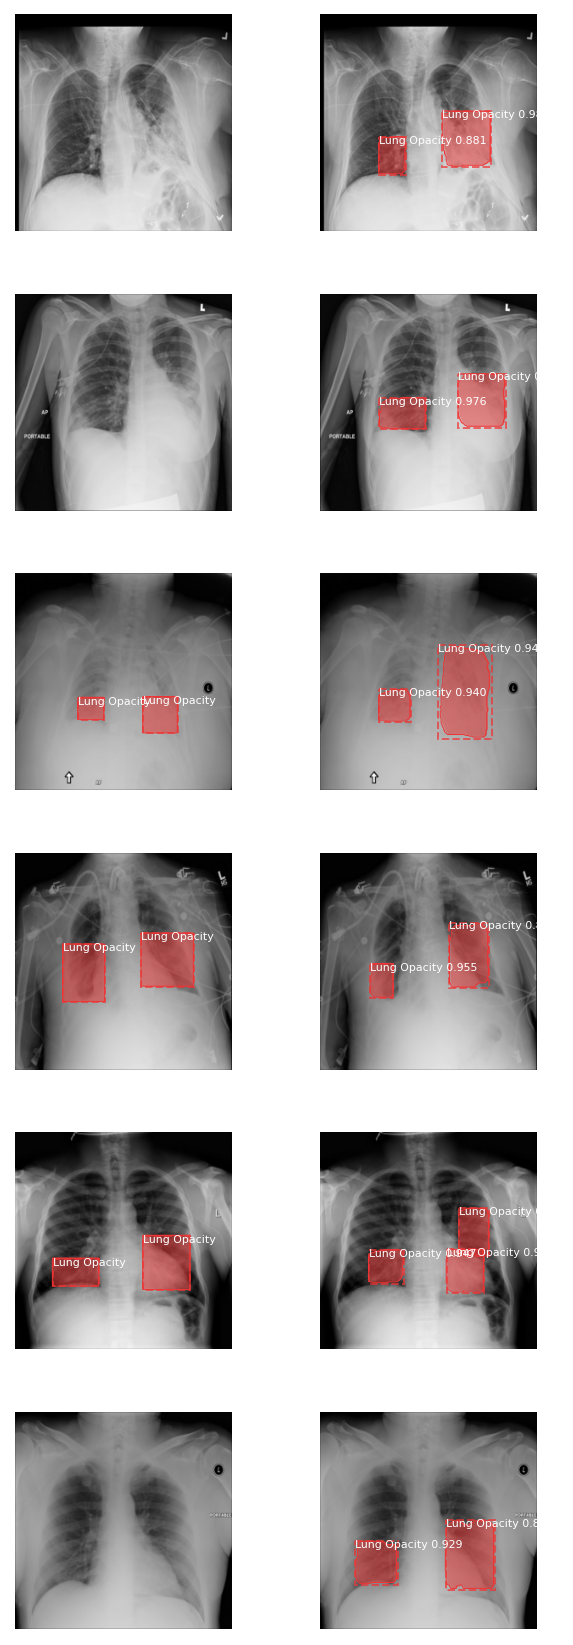

In [60]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset_val, inference_config, image_id)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [26]:
%%time
# get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

Wall time: 113 ms


143e47f2-3d11-44a6-a9eb-b0aaf291db55
[ 86 144 157 198]
x 576 y 344 h 216 w 284
1c9bb237-596f-44c5-b756-4bf50b1d170b
[114  44 160  95]
x 176 y 456 h 204 w 184
[105 140 185 197]
x 560 y 420 h 228 w 320
0106724a-2379-4897-8504-dfaa6db072de
[132  56 173 101]
x 224 y 528 h 180 w 164
29c237f5-8fba-454d-a832-d77fba372312
[116 140 184 192]
x 560 y 464 h 208 w 272
[125  51 172  98]
x 204 y 500 h 188 w 188


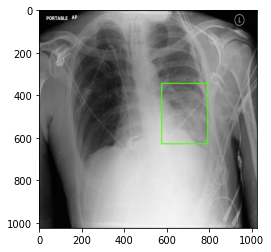

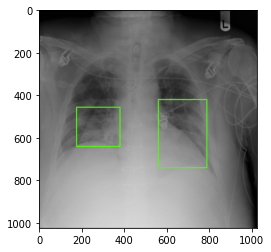

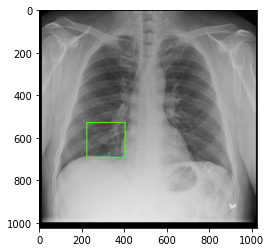

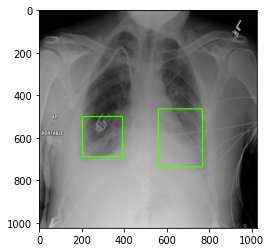

In [33]:
# show a few test image detection example
def visualize():
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)

    # original image
    image = ds.pixel_array

    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]

    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1)
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']:
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1
        height = y2 - y1
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure()
    plt.imshow(image, cmap=plt.cm.gist_gray)

for i in range(4):
    visualize()